In [1]:
"""
This notebook is used for the training of the aligners.
"""

%cd ..

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import copy

from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision import datasets

from alignment.alignment_utils import load_deep_jscc, get_batch_psnr
from alignment.alignment_model import _ConvolutionalAlignment, _LinearAlignment, _ZeroShotAlignment, AlignedDeepJSCC
from utils import image_normalization
import matplotlib.pyplot as plt

from dataset import Vanilla
from model import DeepJSCC
from tqdm import tqdm
import pickle

from concurrent.futures import ThreadPoolExecutor
from functools import partial
from alignment.linear_models import Baseline, LinearOptimizer

/home/lorenzo/repos/Deep-JSCC-PyTorch


/home/lorenzo/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model1_fp = r'alignment/models/autoencoders/upscaled_42.pkl'
model2_fp = r'alignment/models/autoencoders/upscaled_43.pkl'

snr = 30
times = 10
c = 8

dataset = "cifar10"
resolution = 96
n_samples = 1000

batch_size = 64
num_workers = 4
channel = 'AWGN'

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

# Init

## Data

In [3]:
############
# GET DATA #
############

if dataset == 'cifar10':
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((resolution, resolution))])

    train_dataset = datasets.CIFAR10(root='../dataset/', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

    test_dataset = datasets.CIFAR10(root='../dataset/', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

elif dataset == 'imagenet':
    # the size of paper is 128
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((resolution, resolution))])

    print("loading data of imagenet")

    train_dataset = datasets.ImageFolder(root='./dataset/ImageNet/train', transform=transform)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

    test_dataset = Vanilla(root='./dataset/ImageNet/val', transform=transform)
    test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

elif dataset == 'imagenette':
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((resolution, resolution))])

    train_dataset = datasets.Imagenette(root='../dataset/', split="train", download=True, transform=transform)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

    test_dataset = datasets.Imagenette(root='../dataset/', split="val", download=True, transform=transform)
    test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

else:
    raise Exception('Unknown dataset')

In [4]:
class AlignmentDataset(Dataset):
    def __init__(self, dataloader, model1, model2, flat=False):
        self.outputs = []

        model1.eval()
        model1.to(device)

        model2.eval()
        model2.to(device)

        with torch.no_grad():
            for inputs, _ in tqdm(dataloader, desc="Computing model outputs"):
                inputs = inputs.to(device)

                out1 = model1(inputs)
                out2 = model2(inputs)

                for o1, o2 in zip(out1, out2):
                    if flat:
                        o1 = o1.flatten()
                        o2 = o2.flatten()

                    self.outputs.append((o1.cpu(), o2.cpu()))

    def __len__(self):
        return len(self.outputs)

    def __getitem__(self, idx):
        return self.outputs[idx]  

## Utils

In [5]:
def validation(model, dataloader, times):

    model = model.to(device)
    batch_psnr_list = []

    with torch.no_grad():
        for inputs, _ in dataloader:

            inputs = inputs.to(device)
            psnr = torch.zeros(size=(inputs.shape[0], ), device=device)

            for _ in range(times):
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                gt = image_normalization('denormalization')(inputs)
                psnr += get_batch_psnr(demo_image, gt)

            psnr /= times
            batch_mean_psnr = psnr.mean().item()
            batch_psnr_list.append(batch_mean_psnr)

    overall_mean_psnr = sum(batch_psnr_list) / len(batch_psnr_list)

    return overall_mean_psnr

def load_from_checkpoint(path, snr):
    state_dict = torch.load(path, map_location=device)
    from collections import OrderedDict
    new_state_dict = OrderedDict()

    for k, v in state_dict.items():
        name = k.replace('module.','') # remove `module.`
        new_state_dict[name] = v

    model = DeepJSCC(c=c, channel_type=channel, snr=snr)

    model.load_state_dict(new_state_dict)
    model.change_channel(channel, snr)

    return model

## Validation parallelized

In [6]:
def validation_worker(model, inputs, gt, times, worker_id):
    """Worker function for parallel model inference"""
    model.eval()
    psnr_sum = torch.zeros(inputs.shape[0], device=inputs.device)
    
    with torch.no_grad():
        for _ in range(times):
            demo_image = model(inputs)
            demo_image = image_normalization('denormalization')(demo_image)
            psnr_sum += get_batch_psnr(demo_image, gt)
    
    return psnr_sum / times

def validation_parallel_inference(model, dataloader, times, num_workers=None):
    """Version with parallel inference for multiple runs"""
    model = model.to(device)
    model.eval()
    
    # Auto-detect optimal number of workers
    if num_workers is None:
        num_workers = min(times, torch.cuda.device_count() if torch.cuda.is_available() else mp.cpu_count())
    
    total_psnr = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, *_ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]
            
            # Denormalize ground truth once
            gt = image_normalization('denormalization')(inputs)
            
            if times == 1:
                # No need for parallelization with single run
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                batch_psnr = get_batch_psnr(demo_image, gt).sum().item()
            else:
                # Parallel inference for multiple runs
                runs_per_worker = times // num_workers
                remaining_runs = times % num_workers
                
                batch_psnr_sum = torch.zeros(batch_size, device=device)
                
                # Use thread pool for GPU parallelization (better for CUDA)
                with ThreadPoolExecutor(max_workers=num_workers) as executor:
                    futures = []
                    
                    # Submit jobs with different number of runs per worker
                    for i in range(num_workers):
                        worker_runs = runs_per_worker + (1 if i < remaining_runs else 0)
                        if worker_runs > 0:
                            future = executor.submit(
                                validation_worker, 
                                model, inputs, gt, worker_runs, i
                            )
                            futures.append(future)
                    
                    # Collect results
                    for future in futures:
                        batch_psnr_sum += future.result()
                
                batch_psnr = batch_psnr_sum.sum().item()
            
            total_psnr += batch_psnr
            total_samples += batch_size
    
    return total_psnr / total_samples

def validation_parallel_batches(model, dataloader, times, num_workers=4):
    """Version with parallel batch processing"""
    model = model.to(device)
    model.eval()
    
    def process_batch(batch_data):
        inputs, *_ = batch_data
        inputs = inputs.to(device)
        batch_size = inputs.shape[0]
        
        # Denormalize ground truth once
        gt = image_normalization('denormalization')(inputs)
        
        # Accumulate PSNR across multiple runs
        batch_psnr_sum = torch.zeros(batch_size, device=device)
        
        with torch.no_grad():
            for _ in range(times):
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                batch_psnr_sum += get_batch_psnr(demo_image, gt)
        
        batch_mean_psnr = (batch_psnr_sum / times).sum().item()
        return batch_mean_psnr, batch_size
    
    # Process batches in parallel
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = list(executor.map(process_batch, dataloader))
    
    total_psnr = sum(psnr for psnr, _ in results)
    total_samples = sum(samples for _, samples in results)
    
    return total_psnr / total_samples

def validation_vectorized(model, dataloader, times):
    """Vectorized version for maximum efficiency when memory allows"""
    model = model.to(device)
    model.eval()
    
    total_psnr = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, *_ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]
            
            # Denormalize ground truth once
            gt = image_normalization('denormalization')(inputs)
            
            if times == 1:
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                batch_psnr = get_batch_psnr(demo_image, gt).sum().item()
            else:
                # Vectorized computation - process all runs at once
                # Repeat inputs for all runs
                inputs_repeated = inputs.repeat(times, 1, 1, 1)
                
                # Single forward pass for all runs
                demo_images = model(inputs_repeated)
                demo_images = image_normalization('denormalization')(demo_images)
                
                # Reshape to separate runs and batch dimension
                demo_images = demo_images.view(times, batch_size, *demo_images.shape[1:])
                gt_repeated = gt.unsqueeze(0).repeat(times, 1, 1, 1, 1)
                
                # Compute PSNR for all runs at once
                psnr_all_runs = torch.stack([
                    get_batch_psnr(demo_images[i], gt_repeated[i]) 
                    for i in range(times)
                ])
                
                # Average across runs and sum across batch
                batch_psnr = psnr_all_runs.mean(dim=0).sum().item()
            
            total_psnr += batch_psnr
            total_samples += batch_size
    
    return total_psnr / total_samples

# Main validation function with automatic method selection
def validation(model, dataloader, times, method='auto', num_workers=None):
    """
    Optimized validation with multiple parallelization strategies
    
    Args:
        model: The model to validate
        dataloader: Data loader for validation data
        times: Number of inference runs per sample
        method: 'auto', 'vectorized', 'parallel_inference', 'parallel_batches', or 'sequential'
        num_workers: Number of parallel workers (auto-detected if None)
    """
    
    if method == 'auto':
        # Auto-select best method based on conditions
        if times == 1:
            method = 'sequential'
        elif times <= 4 and torch.cuda.is_available():
            method = 'vectorized'  # Best for GPU with moderate times
        elif times > 4:
            method = 'parallel_inference'  # Best for many inference runs
        else:
            method = 'parallel_batches'  # Best for CPU or complex cases
    
    if method == 'vectorized':
        return validation_vectorized(model, dataloader, times)
    elif method == 'parallel_inference':
        return validation_parallel_inference(model, dataloader, times, num_workers)
    elif method == 'parallel_batches':
        return validation_parallel_batches(model, dataloader, times, num_workers)
    else:  # sequential
        return validation_sequential(model, dataloader, times)

def validation_sequential(model, dataloader, times):
    """Original optimized sequential version for comparison"""
    model = model.to(device)
    model.eval()
    
    total_psnr = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, *_ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]
            
            gt = image_normalization('denormalization')(inputs)
            batch_psnr_sum = torch.zeros(batch_size, device=device)
            
            for _ in range(times):
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                batch_psnr_sum += get_batch_psnr(demo_image, gt)
            
            batch_mean_psnr = (batch_psnr_sum / times).sum().item()
            total_psnr += batch_mean_psnr
            total_samples += batch_size
    
    return total_psnr / total_samples

# Least Squares

## Functions

In [12]:
def dataset_to_matrices(dataset, batch_size=128):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    data_1 = []
    data_2 = []
    
    for batch in loader:
        data_1.append(batch[0])
        data_2.append(batch[1])

    return torch.cat(data_1, dim=0), torch.cat(data_2, dim=0)

def aligner_least_squares(matrix_1, matrix_2):
    Y = matrix_1.T
    Z = matrix_2.T

    Q = Y @ Z.T @ torch.inverse(Z @ Z.T)

    return _LinearAlignment(align_matrix=Q)

## Train

In [13]:
model1 = load_from_checkpoint(model1_fp, snr).encoder
model2 = load_from_checkpoint(model2_fp, snr).encoder

data = AlignmentDataset(train_loader, model1, model2, flat=True)
indices = torch.randperm(len(data))[:n_samples]
subset = Subset(data, indices)

matrix_1, matrix_2 = dataset_to_matrices(subset)

Computing model outputs: 100%|██████████| 782/782 [00:09<00:00, 85.64it/s] 


In [14]:
aligner = aligner_least_squares(matrix_1, matrix_2)

with open(r'alignment/models/plots/luglio_1000/aligner_linear.pkl', 'wb') as f:
    pickle.dump(aligner, f)

## Validation

In [127]:
model1 = load_deep_jscc(model1_fp, snr, c, "AWGN")
model2 = load_deep_jscc(model2_fp, snr, c, "AWGN")

encoder = copy.deepcopy(model1.encoder)
decoder = copy.deepcopy(model2.decoder)

with open(r'alignment/models/aligner_lin.pkl', 'rb') as f:
    aligner = pickle.load(f)

aligned_model = AlignedDeepJSCC(encoder, decoder, aligner, snr, channel)

print(f"Got a PSNR of {validation_vectorized(aligned_model, test_loader, times):.2f}")

Got a PSNR of 5.25


# Linear Neural

## Functions

In [16]:
def aligner_linear_neural(dataloader, epochs_max, ratio, patience, check_interval, min_delta):
    aligner = _LinearAlignment(size=resolution*resolution*3*2//ratio).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(aligner.parameters(), lr=1e-3)

    best_loss = float('inf')
    checks_without_improvement = 0
    epoch = 0

    while True:
        epoch_loss = 0.0

        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = aligner(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch += 1

        if epoch % check_interval == 0:
            avg_loss = epoch_loss / len(dataloader)
            if best_loss - avg_loss > min_delta:
                best_loss = avg_loss
                checks_without_improvement = 0
            else:
                checks_without_improvement += 1

            if checks_without_improvement >= patience:
                break

        if epoch > epochs_max:
            break

        print(epoch, epoch_loss)

    print(f"Done. Trained for {epoch} epochs.")

    return aligner

## Train

In [17]:
model1 = load_from_checkpoint(model1_fp, snr).encoder
model2 = load_from_checkpoint(model2_fp, snr).encoder

data = AlignmentDataset(train_loader, model1, model2, flat=False)
indices = torch.randperm(len(data))[:n_samples]
subset = Subset(data, indices)
dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True)

Computing model outputs: 100%|██████████| 782/782 [00:09<00:00, 81.91it/s]


In [102]:
aligner = aligner_linear_neural(dataloader=dataloader,
                                epochs_max=10000,
                                ratio=6,
                                patience=3,
                                check_interval=1,
                                min_delta=1e-5)

1 12.93152379989624
2 6.831671476364136
3 10.945549964904785
4 5.949641942977905
5 7.1338746547698975
6 3.6406203508377075
7 4.407152414321899
8 3.1130728721618652
9 2.2155306935310364
10 2.42379367351532
11 1.3477707505226135
12 1.568522572517395
13 1.2500128149986267
14 0.9946581125259399
15 1.017516851425171
16 0.7494518756866455
17 0.5999117195606232
18 0.5195353478193283
19 0.4325716346502304
20 0.39526116847991943
21 0.3152727633714676
22 0.2736031860113144
23 0.2261369451880455
24 0.19211646169424057
25 0.17357826232910156
26 0.13860171288251877
27 0.12728406488895416
28 0.10622132942080498
29 0.08520125225186348
30 0.07779017835855484
31 0.06409173458814621
32 0.05488092638552189
33 0.0452419463545084
34 0.04517090879380703
35 0.03620693273842335
36 0.032482560724020004
37 0.024500436149537563
38 0.02472590934485197
39 0.018841326236724854
40 0.018454289063811302
41 0.015020058490335941
42 0.013421061914414167
43 0.010677082929760218
44 0.010473661590367556
45 0.009282292798161

In [103]:
aligner_fp = r'alignment/models/aligner_neural_128.pkl'

with open(aligner_fp, 'wb') as f:
    pickle.dump(aligner.to("cpu"), f)

## Validation

In [104]:
model1 = load_deep_jscc(model1_fp, snr, c, "AWGN")
model2 = load_deep_jscc(model2_fp, snr, c, "AWGN")

encoder = copy.deepcopy(model1.encoder)
decoder = copy.deepcopy(model2.decoder)

with open(aligner_fp, 'rb') as f:
    aligner = pickle.load(f)

aligned_model = AlignedDeepJSCC(encoder, decoder, aligner, snr, channel)

print(f"Got a PSNR of {validation_vectorized(aligned_model, test_loader, times):.2f}")

Got a PSNR of 13.95


## Luglio

In [19]:
from channel import Channel

for snr in [-20, -10, 0, 10, 20, 30]:
    epochs_max=10000
    ratio=6
    patience=5
    check_interval=1
    min_delta=1e-5

    aligner = _LinearAlignment(size=resolution*resolution*3*2//ratio).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(aligner.parameters(), lr=1e-3)
    channel = Channel("AWGN", snr)

    best_loss = float('inf')
    checks_without_improvement = 0
    epoch = 0

    while True:
        epoch_loss = 0.0

        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = aligner(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch += 1

        if epoch % check_interval == 0:
            avg_loss = epoch_loss / len(dataloader)
            if best_loss - avg_loss > min_delta:
                best_loss = avg_loss
                checks_without_improvement = 0
            else:
                checks_without_improvement += 1

            if checks_without_improvement >= patience:
                break

        if epoch > epochs_max:
            break

        print(epoch, epoch_loss)

    print(f"Done. Trained for {epoch} epochs.")

    aligner_fp = r'alignment/models/plots/luglio_1000/aligner_neural_'+str(snr)+'.pkl'

    with open(aligner_fp, 'wb') as f:
        pickle.dump(aligner.to("cpu"), f)

1 28.914687275886536
2 10.789028525352478
3 4.648629724979401
4 2.136127330362797
5 1.094697654247284
6 0.6230440512299538
7 0.3897890392690897
8 0.2614554278552532
9 0.18342218175530434
10 0.14933680836111307
11 0.1295545152388513
12 0.11829823534935713
13 0.11821307614445686
14 0.1283187442459166
15 0.1710246568545699
16 0.2238693805411458
Done. Trained for 17 epochs.
1 29.336658120155334
2 10.920869886875153
3 4.638838052749634
4 2.122847355902195
5 1.0786573737859726
6 0.6034347154200077
7 0.37001027911901474
8 0.24812200665473938
9 0.17786475736647844
10 0.13540122797712684
11 0.12705365475267172
12 0.12473008269444108
13 0.12681469321250916
14 0.15227781981229782
15 0.18672831449657679
16 0.24648768175393343
Done. Trained for 17 epochs.
1 28.456438660621643
2 10.611071825027466
3 4.574502721428871
4 2.140170358121395
5 1.1083907037973404
6 0.6249242648482323
7 0.39132557809352875
8 0.26427608262747526
9 0.20342969056218863
10 0.16806279495358467
11 0.14702619658783078
12 0.137769

## Plot

In [ ]:
def increasing_dataset_size():
    batch_size = 128
    n_batches = 782
    times = 10

    for b in range(1, n_batches+1):

        # dataset to matrices
        loader = DataLoader(data, batch_size=batch_size, shuffle=False)
        data_1 = []
        data_2 = []

        i = 0
        for batch in loader:
            data_1.append(batch[0])
            data_2.append(batch[1])
            i += 1

            if i == b:
                break

        matrix_1 = torch.cat(data_1, dim=0)
        matrix_2 = torch.cat(data_2, dim=0)

        # get model
        Y = matrix_1.T
        Z = matrix_2.T

        Q = Y @ Z.T @ torch.inverse(Z @ Z.T)

        with open(r'alignment\models\aligner.pkl', 'wb') as f:
            pickle.dump(Q, f)

        # load aligned model
        aligned_model = load_aligned_model(model1_fp, model2_fp, r'alignment\models\aligner.pkl', "linear" snr, c, channel)

        print(f"For {b} batches we get a PSNR of {validation(aligned_model, test_loader, times):.2f}")

In [ ]:
increasing_dataset_size()

For 1 batches we get a PSNR of 5.22
For 2 batches we get a PSNR of 5.37
For 3 batches we get a PSNR of 5.15
For 4 batches we get a PSNR of 5.26
For 5 batches we get a PSNR of 5.38
For 6 batches we get a PSNR of 5.14
For 7 batches we get a PSNR of 5.36
For 8 batches we get a PSNR of 6.40
For 9 batches we get a PSNR of 18.09
For 10 batches we get a PSNR of 21.53
For 11 batches we get a PSNR of 23.44
For 12 batches we get a PSNR of 24.43
For 13 batches we get a PSNR of 25.09
For 14 batches we get a PSNR of 25.57
For 15 batches we get a PSNR of 25.88
For 16 batches we get a PSNR of 26.14
For 17 batches we get a PSNR of 26.33
For 18 batches we get a PSNR of 26.50
For 19 batches we get a PSNR of 26.63
For 20 batches we get a PSNR of 26.74
For 21 batches we get a PSNR of 26.84
For 22 batches we get a PSNR of 26.90
For 23 batches we get a PSNR of 26.97
For 24 batches we get a PSNR of 27.03
For 25 batches we get a PSNR of 27.08
For 26 batches we get a PSNR of 27.13
For 27 batches we get a PSNR 

KeyboardInterrupt: 

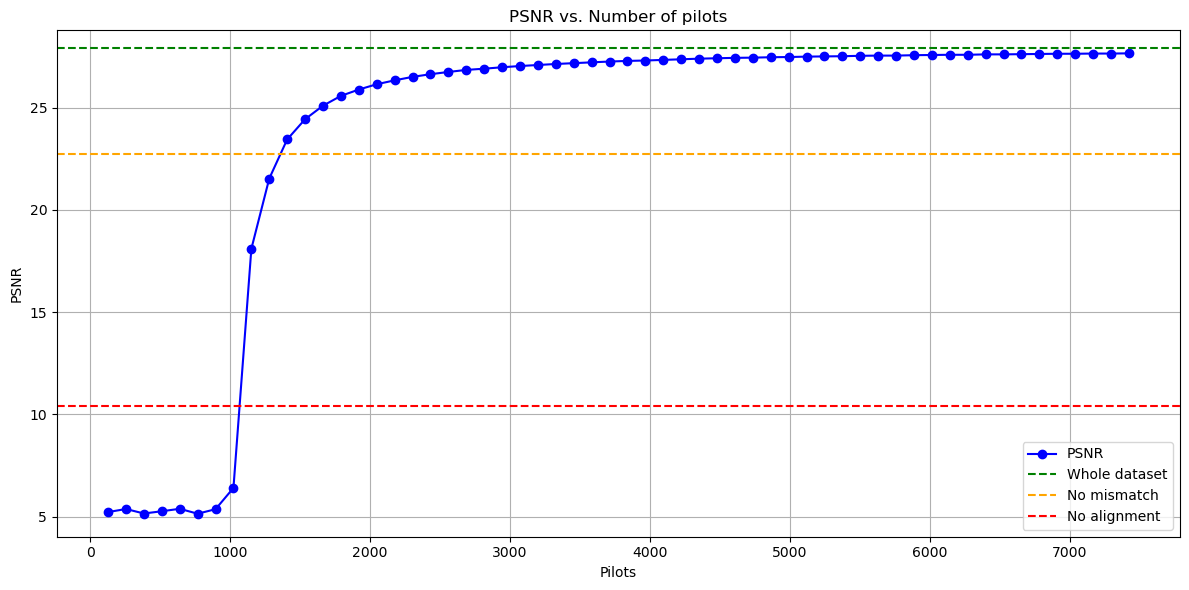

In [ ]:
psnr_values = [
    5.22, 5.37, 5.15, 5.26, 5.38, 5.14, 5.36, 6.40, 18.09, 21.53,
    23.44, 24.43, 25.09, 25.57, 25.88, 26.14, 26.33, 26.50, 26.63, 26.74,
    26.84, 26.90, 26.97, 27.03, 27.08, 27.13, 27.17, 27.21, 27.25, 27.28,
    27.30, 27.33, 27.36, 27.39, 27.41, 27.43, 27.44, 27.46, 27.47, 27.49,
    27.50, 27.51, 27.53, 27.54, 27.54, 27.56, 27.57, 27.58, 27.58, 27.60,
    27.60, 27.61, 27.62, 27.63, 27.63, 27.64, 27.64, 27.65
]

batches = list(range(1, len(psnr_values) + 1))

# Convert batches to number of elements (batch size = 128)
elements = [batch * 128 for batch in batches]

# Plotting with elements instead of batches
plt.figure(figsize=(12, 6))
plt.plot(elements, psnr_values, marker='o', linestyle='-', color='b', label='PSNR')

# Adding horizontal lines
plt.axhline(y=27.90, color='g', linestyle='--', linewidth=1.5, label='Whole dataset')
plt.axhline(y=22.74, color='orange', linestyle='--', linewidth=1.5, label='No mismatch')
plt.axhline(y=10.39, color='red', linestyle='--', linewidth=1.5, label='No alignment')

# Titles and labels
plt.title('PSNR vs. Number of pilots')
plt.xlabel('Pilots')
plt.ylabel('PSNR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Convolutional

## Functions

In [117]:
def aligner_convolutional(dataloader, epochs_max, patience, check_interval, min_delta):
    aligner = _ConvolutionalAlignment(in_channels=2*c, out_channels=2*c, kernel_size=5).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(aligner.parameters(), lr=1e-3)

    best_loss = float('inf')
    checks_without_improvement = 0
    epoch = 0

    while True:
        epoch_loss = 0.0

        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = aligner(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch += 1

        if epoch % check_interval == 0:
            avg_loss = epoch_loss / len(dataloader)
            if best_loss - avg_loss > min_delta:
                best_loss = avg_loss
                checks_without_improvement = 0
            else:
                checks_without_improvement += 1

            if checks_without_improvement >= patience:
                break

        if epoch > epochs_max:
            break

        print(epoch, epoch_loss)

    print(f"Done. Trained for {epoch} epochs.")

    return aligner

## Train

In [118]:
model1 = load_from_checkpoint(model1_fp, snr).encoder
model2 = load_from_checkpoint(model2_fp, snr).encoder

data = AlignmentDataset(train_loader, model1, model2, flat=False)
dataloader = DataLoader(data, batch_size=1024, shuffle=True)

Computing model outputs: 100%|██████████| 782/782 [00:14<00:00, 53.73it/s]


In [119]:
aligner = aligner_convolutional(dataloader=dataloader,
                                epochs_max=10000,
                                patience=3,
                                check_interval=1,
                                min_delta=1e-5)

1 30.594786882400513
2 15.752619236707687
3 12.285207495093346
4 10.689584240317345
5 9.826133042573929
6 9.316815167665482
7 8.998211324214935
8 8.787191644310951
9 8.642968773841858
10 8.536908715963364
11 8.458377867937088
12 8.398363828659058
13 8.350581422448158
14 8.314190909266472
15 8.281849429011345
16 8.256072998046875
17 8.235350102186203
18 8.216070517897606
19 8.198744893074036
20 8.187667697668076
21 8.174174919724464
22 8.16699931025505
23 8.155365392565727
24 8.146173059940338
25 8.138062879443169
26 8.132605969905853
27 8.12743093073368
28 8.121868342161179
29 8.117968663573265
30 8.114447951316833
31 8.108071967959404
32 8.105756133794785
33 8.099421247839928
34 8.099458158016205
35 8.096932291984558
36 8.094442874193192
37 8.09535114467144
38 8.088228017091751
39 8.087041765451431
40 8.085282862186432
41 8.086929932236671
42 8.08282245695591
43 8.08285416662693
44 8.079031333327293
45 8.078379854559898
46 8.078362911939621
47 8.078119039535522
Done. Trained for 48 ep

In [120]:
aligner_fp = r'alignment\models\aligner_conv.pkl'

with open(aligner_fp, 'wb') as f:
    pickle.dump(aligner, f)

## Validation

In [121]:
model1 = load_deep_jscc(model1_fp, snr, c, "AWGN")
model2 = load_deep_jscc(model2_fp, snr, c, "AWGN")

encoder = copy.deepcopy(model1.encoder)
decoder = copy.deepcopy(model2.decoder)

with open(aligner_fp, 'rb') as f:
    aligner = pickle.load(f)

aligned_model = AlignedDeepJSCC(encoder, decoder, aligner, snr, channel)

print(f"Got a PSNR of {validation_vectorized(aligned_model, test_loader, times):.2f}")

Got a PSNR of 28.78


# Zero-shot

In [57]:
model1 = load_from_checkpoint(model1_fp, snr).encoder
model2 = load_from_checkpoint(model2_fp, snr).encoder

data = AlignmentDataset(train_loader, model1, model2, flat=True)

Computing model outputs: 100%|██████████| 782/782 [00:10<00:00, 74.07it/s] 


In [63]:
indices = torch.randperm(len(data))[:n_samples]
subset = Subset(data, indices)

dataloader = DataLoader(subset, batch_size=len(subset))
input, output = next(iter(dataloader))

In [64]:
flattened_image_size = 8192*2
seed=42

baseline = Baseline(
        input_dim=flattened_image_size,
        output_dim=flattened_image_size,
        channel_matrix=torch.eye(1, dtype=torch.complex64),
        snr=snr,
        proto=n_samples,
        channel_usage=None,
        typology='post',
        strategy='PFE',
        use_channel=True,
        seed=seed,
)

baseline.fit(input, output)

aligner = _ZeroShotAlignment(baseline.A)

In [108]:
aligner_fp = r'alignment/models/aligner_zeroshot/zeroshot_2.pkl'

with open(aligner_fp, 'wb') as f:
    pickle.dump(aligner, f)

In [109]:
model1 = load_deep_jscc(model1_fp, snr, c, "AWGN")
model2 = load_deep_jscc(model2_fp, snr, c, "AWGN")

encoder = copy.deepcopy(model1.encoder)
decoder = copy.deepcopy(model2.decoder)

with open(aligner_fp, 'rb') as f:
    aligner = pickle.load(f)

aligned_model = AlignedDeepJSCC(encoder, decoder, aligner, snr, channel)

print(f"Got a PSNR of {validation_vectorized(aligned_model, test_loader, times):.2f}")

Got a PSNR of 14.97


In [110]:
batch_psnr_list = []

with torch.no_grad():
    for inputs, _ in test_loader:

        inputs = inputs.to(device)
        psnr = torch.zeros(size=(inputs.shape[0], ), device=device)

        for _ in range(times):
            demo_image = encoder(inputs)
            shape = demo_image.shape

            demo_image = demo_image.flatten(start_dim=1).to("cpu")
            demo_image = baseline.transform(demo_image).to(device)

            demo_image = demo_image.reshape(shape)
            demo_image = decoder(demo_image)

            demo_image = image_normalization('denormalization')(demo_image)
            gt = image_normalization('denormalization')(inputs)
            psnr += get_batch_psnr(demo_image, gt)

        psnr /= times
        batch_mean_psnr = psnr.mean().item()
        batch_psnr_list.append(batch_mean_psnr)

overall_mean_psnr = sum(batch_psnr_list) / len(batch_psnr_list)

overall_mean_psnr

13.567258919879889

In [29]:
model1 = load_deep_jscc(model1_fp, snr, c, "AWGN")
model2 = load_deep_jscc(model2_fp, snr, c, "AWGN")

encoder = copy.deepcopy(model1.encoder)
decoder = copy.deepcopy(model2.decoder)

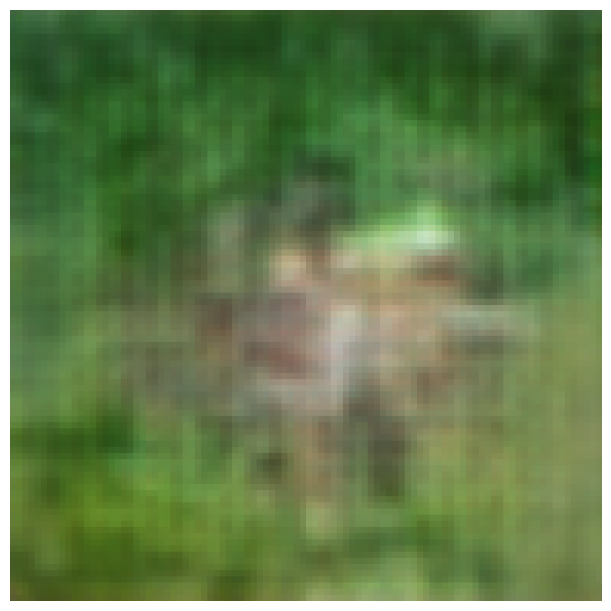

In [65]:
import numpy as np
from PIL import Image

demo_image = encoder(test_dataset[4][0].to("cpu"))
shape = demo_image.shape

demo_image = demo_image.reshape(1, -1).to("cpu")
demo_image = baseline.transform(demo_image).to("cpu")

demo_image = demo_image.reshape(shape)
demo_image = decoder(demo_image)

demo_image = image_normalization('denormalization')(demo_image)
demo_image = image_normalization('normalization')(demo_image)

demo_image = demo_image.cpu().detach().numpy()  # (C, H, W)
demo_image = demo_image.transpose(1, 2, 0)  # convert to (H, W, C) for PIL

# convert to PIL image and upscale
pil_image = Image.fromarray((demo_image * 255).astype(np.uint8))
new_size = (pil_image.width * 8, pil_image.height * 8)
pil_image = pil_image.resize(new_size, Image.NEAREST)  # Use NEAREST or BICUBIC

# show the upscaled image
plt.figure(figsize=(new_size[0] / 100, new_size[1] / 100), dpi=100)
plt.imshow(pil_image)
plt.axis('off')
plt.show()

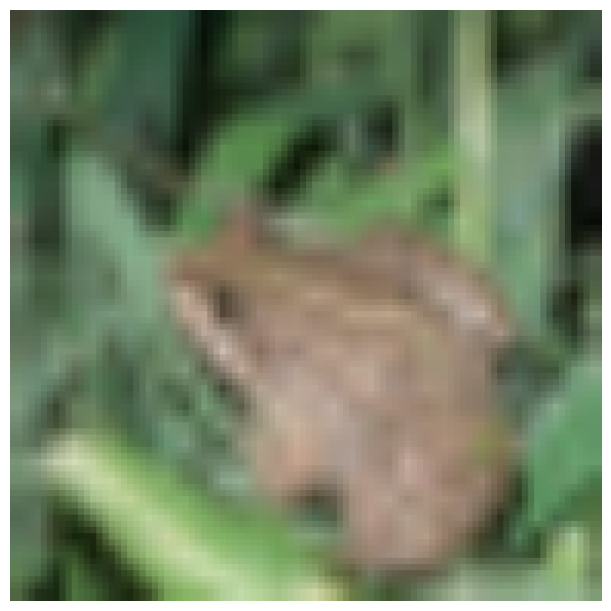

In [66]:
demo_image = test_dataset[4][0].to(device)

demo_image = demo_image.cpu().detach().numpy()  # (C, H, W)
demo_image = demo_image.transpose(1, 2, 0)  # convert to (H, W, C) for PIL

# convert to PIL image and upscale
pil_image = Image.fromarray((demo_image * 255).astype(np.uint8))
new_size = (pil_image.width * 8, pil_image.height * 8)
pil_image = pil_image.resize(new_size, Image.NEAREST)  # Use NEAREST or BICUBIC

# show the upscaled image
plt.figure(figsize=(new_size[0] / 100, new_size[1] / 100), dpi=100)
plt.imshow(pil_image)
plt.axis('off')
plt.show()

In [ ]:
batch_psnr_list = []

with torch.no_grad():
    for inputs, _ in test_loader:

        inputs = inputs.to(device)
        psnr = torch.zeros(size=(inputs.shape[0], ), device=device)

        for _ in range(times):
            demo_image = encoder(inputs)
            shape = demo_image.shape

            demo_image = demo_image.flatten(start_dim=1).to("cpu")
            demo_image = baseline.transform(demo_image).to(device)

            demo_image = demo_image.reshape(shape)
            demo_image = decoder(demo_image)

            demo_image = image_normalization('denormalization')(demo_image)
            gt = image_normalization('denormalization')(inputs)
            psnr += get_batch_psnr(demo_image, gt)

        psnr /= times
        batch_mean_psnr = psnr.mean().item()
        batch_psnr_list.append(batch_mean_psnr)

overall_mean_psnr = sum(batch_psnr_list) / len(batch_psnr_list)

overall_mean_psnr